<h3><center>$\frac{\partial A}{\partial t} = D_A \nabla^2 A + b_A +  \frac{V_A}{(1 + \frac{D}{k_{DA}})^n} - \mu_A A$</center></h3>

<h3><center>$\frac{\partial B}{\partial t} = D_B \nabla^2 B + b_B +  \frac{V_B}{(1 + \frac{k_{AA}}{A})^n (1 + \frac{E}{k_{EB}})^n} - \mu_A B$</center></h3>

<h3><center>$\frac{\partial C}{\partial t} = b_C +  \frac{V_C}{(1 + \frac{D}{k_{DA}})^n } - \mu_{lvA} C$</center></h3>

<h3><center>$\frac{\partial D}{\partial t} = b_D +  \frac{V_D}{(1 + \frac{k_{BD}}{B})^n} - \mu_{lvA} D$</center></h3>

<h3><center>$\frac{\partial E}{\partial t} = b_E +  \frac{V_E}{(1 + \frac{C}{k_{CE}})^n (1 + \frac{F}{k_{FE}})^n (1 + \frac{k_{EE}}{E})^n} - \mu_{lvA} E$</center></h3>

<h3><center>$\frac{\partial F}{\partial t} = b_F +  \frac{V_F}{(1 + \frac{k_{BD}}{B})^n} - \mu_{lvA} F$</center></h3>

If
<h3><center>$(A, B, C, D, E, F) \rightarrow (\alpha_A A, \alpha_B B, \alpha_C C, \alpha_D D, \alpha_E E, \alpha_F F)$,</center></h3>

then
<h3><center>$(b_A, b_B, b_C, b_D, b_E, b_F) \rightarrow (\alpha_A b_A , \alpha_B b_B , \alpha_C b_C , \alpha_D b_D , \alpha_E b_E , \alpha_F b_F )$,</center></h3>
<h3><center>$(V_A, V_B, V_C, V_D, V_E, V_F) \rightarrow (\alpha_A V_A , \alpha_B V_B , \alpha_C V_C , \alpha_D V_D , \alpha_E V_E , \alpha_F V_F )$,</center></h3>

and

<h3><center>$(k_{DA}, k_{AA}, k_{EB}, k_{BD}, k_{CE}, k_{FE}, k_{EE}) \rightarrow (\alpha_D k_{DA}, \alpha_A k_{AA}, \alpha_E k_{EB}, \alpha_B k_{BD}, \alpha_C k_{CE}, \alpha_F k_{FE}, \alpha_E k_{EE})$,</center></h3>

In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

#import os
#os.environ["LD_LIBRARY_PATH"]="/local/cuda-10.2/lib64"
#sys.path.append("/local/cuda-10.2/bin")


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes

2022-09-10 13:58:17.318214: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-09-10 13:58:28.405779: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-09-10 13:58:28.428952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-09-10 13:58:28.428986: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-09-10 13:58:28.431809: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-09-10 13:58:28.434614: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

In [2]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [3]:
df_params.head()

,Va,Vb,Vc,Vd,Ve,Vf,ba,bb,bc,bd,...,kaa,kbd,kce,kda,keb,kee,kfe,mua,mulva,n
0,360.066204,69.840434,33.468912,283.316201,79.328098,35.847305,0.007714,0.009772,0.010261,0.008996,...,2.316063,2.874391,88.732068,9.363779,9.627162,0.275728,5.519184,4.664757,1.485684,2.0
1,271.955874,101.868916,28.546540,347.711607,84.727223,41.786928,0.008341,0.012020,0.013054,0.010064,...,4.883066,3.640181,99.577576,9.439324,7.552942,0.252092,4.607892,2.973656,1.423090,2.0
2,310.495835,79.551016,51.789526,197.624749,51.961358,40.627957,0.010750,0.015593,0.009346,0.013251,...,3.245317,4.944193,34.494922,13.954478,8.398245,0.299176,4.757444,4.151729,1.129469,2.0
3,368.363031,99.843451,51.223075,312.732434,89.436871,49.564425,0.008238,0.010022,0.007271,0.007357,...,2.941270,2.693431,89.807684,10.478264,7.656785,0.347844,6.552310,3.452419,1.213001,2.0
4,252.138904,90.823276,43.880020,293.190760,87.402367,59.800131,0.008995,0.008820,0.007773,0.011784,...,4.101435,3.625196,60.758534,9.479563,10.618988,0.174654,3.911595,4.190837,1.634196,2.0


In [4]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


# Test two: Using mask

In [5]:
df_params.loc[194]

Va       225.044878
Vb        99.224637
Vc        35.464353
Vd       215.788176
Ve        78.554844
Vf        21.347275
ba         0.008047
bb         0.003751
bc         0.006264
bd         0.009229
be         0.009094
bf         0.010251
d_A        1.000000
d_B        0.003006
kaa        3.042316
kbd        1.677592
kce       50.607851
kda        9.922708
keb       10.911610
kee        0.227893
kfe        5.822360
mua        4.134153
mulva      1.364225
n          2.000000
Name: 194, dtype: float64

In [6]:
ID = 194
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)

##########################
# select the last two snapshots
t_star = t_star[-2:]
T = len(t_star)
data = data[:, :, :, -2::]


In [7]:
##############################
# Normalise the concentration 
# such that [a, b] -> [a, a+1]
alpha_A = np.max(data[0, ...]) - np.min(data[0, ...])
alpha_B = np.max(data[1, ...]) - np.min(data[1, ...])
alpha_C = np.max(data[2, ...]) - np.min(data[2, ...])
alpha_D = np.max(data[3, ...]) - np.min(data[3, ...])
alpha_E = np.max(data[4, ...]) - np.min(data[4, ...])
alpha_F = np.max(data[5, ...]) - np.min(data[5, ...])

data[0, ...] = data[0, ...]/alpha_A
data[1, ...] = data[1, ...]/alpha_B
data[2, ...] = data[2, ...]/alpha_C
data[3, ...] = data[3, ...]/alpha_D
data[4, ...] = data[4, ...]/alpha_E
data[5, ...] = data[5, ...]/alpha_F

In [8]:
model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])[dataset['pde_mask'] > 0, :]

In [9]:
dataset['pde_mask'].shape

(45000,)

In [10]:
print(f"alpha_a={alpha_A}")
print(f"alpha_b={alpha_B}")
print(f"alpha_c={alpha_C}")
print(f"alpha_d={alpha_D}")
print(f"alpha_e={alpha_E}")
print(f"alpha_f={alpha_F}")

print(f"b_a={df_params.ba[ID]/alpha_A}")
print(f"b_b={df_params.bb[ID]/alpha_B}")
print(f"b_c={df_params.bc[ID]/alpha_C}")
print(f"b_d={df_params.bd[ID]/alpha_D}")
print(f"b_e={df_params.be[ID]/alpha_E}")
print(f"b_f={df_params.bf[ID]/alpha_F}")

print(f"Va={df_params.Va[ID]/alpha_A}")
print(f"Vb={df_params.Vb[ID]/alpha_B}")
print(f"Vc={df_params.Vc[ID]/alpha_C}")
print(f"Vd={df_params.Vd[ID]/alpha_D}")
print(f"Ve={df_params.Ve[ID]/alpha_E}")
print(f"Vf={df_params.Vf[ID]/alpha_F}")

print(f"kaa={df_params.kaa[ID]/alpha_A}")
print(f"kbd={df_params.kbd[ID]/alpha_B}")
print(f"kce={df_params.kce[ID]/alpha_C}")
print(f"kda={df_params.kda[ID]/alpha_D}")
print(f"keb={df_params.keb[ID]/alpha_E}")
print(f"kee={df_params.kee[ID]/alpha_E}")
print(f"kfe={df_params.kfe[ID]/alpha_F}")


alpha_a=2.7900181428906206
alpha_b=6.5340563745362505
alpha_c=12.575300922322196
alpha_d=171.05758799781063
alpha_e=61.9847207887942
alpha_f=16.93029837472404
b_a=0.0028841989566258737
b_b=0.0005740004044291514
b_c=0.0004980922280968829
b_d=5.3951219617737745e-05
b_e=0.0001467183935271656
b_f=0.0006054828995302617
Va=80.66072218746676
Vb=15.18576389328972
Vc=2.8201594222954367
Vd=1.2614943227252002
Ve=1.2673259388619327
Vf=1.2608918634236623
kaa=1.0904288126393775
kbd=0.25674590132089914
kce=4.024384875727391
kda=0.058007994696354336
keb=0.17603709079099442
kee=0.0036766036316541097
kfe=0.3439017946423292


In [11]:
#layers = [3, 256, 256, 512, 512, 1024, 1024, 6]
layers = [3, 512, 512, 1024, 1024, 1024, 6]
#layers = [3, 64, 64, 64, 64, 6]
#layers = [3, 1024, 1024, 1024, 1024, 6]

pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_loss = Circuit2_variant5716(dtype=tf.float32, 
        D_A=df_params.d_A[ID],
        D_B = df_params.d_B[ID],
        b_A=df_params.ba[ID]/alpha_A,
        b_B=df_params.bb[ID]/alpha_B,
        b_C=df_params.bc[ID]/alpha_C,
        b_D=df_params.bd[ID]/alpha_D,
        b_E=df_params.be[ID]/alpha_E,
        #b_F=df_params.bf[ID]/alpha_F,
        V_A=df_params.Va[ID]/alpha_A,
        V_B=df_params.Vb[ID]/alpha_B,
        V_C=df_params.Vc[ID]/alpha_C,
        V_D=df_params.Vd[ID]/alpha_D,
        V_E=df_params.Ve[ID]/alpha_E,
        V_F=df_params.Vf[ID]/alpha_F,
        k_AA=df_params.kaa[ID]/alpha_A,
        k_BD=df_params.kbd[ID]/alpha_B,
        k_CE=df_params.kce[ID]/alpha_C,
        k_DA=df_params.kda[ID]/alpha_D,
        k_EB=df_params.keb[ID]/alpha_E,
        k_EE=df_params.kee[ID]/alpha_E,
        k_FE=df_params.kfe[ID]/alpha_F,
        mu_A=df_params.mua[ID],
        mulv_A=df_params.mulva[ID])

model = TINN_multi_nodes(pinn, 
                pde_loss, 
                log_loss=True,
                nodes_n = nodes_n,
                node_names = node_names,
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                alpha = 0.9, 
                #lambdas_pre = [ 1.,  1.,  1.,  1.,  1.,  1., 10.,  1.,  1.,  1.,  1.,  1.],
                print_precision=".10f")

## Inital Period to cool down

In [12]:
results = model.train(
        epochs = 20,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        X_pde = pde_X,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=False,
        sample_gradients=False,
        regularise=False,
        epoch_callback = None)

model.optimizer.lr.assign(5e-4)

results2 = model.train(
        epochs = 100,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        X_pde = pde_X,
        print_interval=10,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)

model.optimizer.lr.assign(2.5e-4)

results3 = model.train(
        epochs = 500,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        X_pde = pde_X,
        print_interval=50,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)

model.optimizer.lr.assign(1e-4)

results4 = model.train(
        epochs = 1000,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        X_pde = pde_X,
        print_interval=50,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)

model.optimizer.lr.assign(5e-5)

results5 = model.train(
        epochs = 18000,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        X_pde = pde_X,
        print_interval=200,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0


2022-09-10 13:59:08.708259: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-09-10 13:59:12.893142: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.9383424520
total loss: 19.5178466888, total regularisd loss (sum of batches): -62.6748516560
obs A loss: 0.7445050768, pde A loss: 14.5079091080
obs B loss: 1.5455136431, pde B loss: 6.9273381899
obs C loss: 0.7686018372, pde C loss: 1.7873432598
obs D loss: 1.0622684670, pde D loss: 2.4359641056
obs E loss: 0.4923740203, pde E loss: 0.9978306201
obs F loss: 0.6151614002, pde F loss: 10.3475506649
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000
b_F: 9.95589 
Time taken: 14.53s

Start of epoch 1
Training observations acc over epoch: 0.3549385667
total loss: 9.9477127667, total regularisd loss (sum of batches): -1156.3232269287
obs A loss: 0.4863035026, pde A loss: 0.6315

Training observations acc over epoch: 0.3102747798
total loss: 9.1931958805, total regularisd loss (sum of batches): -1585.2714462280
obs A loss: 0.2314088294, pde A loss: 0.6238654320
obs B loss: 0.2495369262, pde B loss: 0.8206644588
obs C loss: 0.1183220980, pde C loss: 0.0220061722
obs D loss: 0.3509920131, pde D loss: 0.0614935071
obs E loss: 0.2362094799, pde E loss: 0.0540754742
obs F loss: 0.5184721980, pde F loss: 9.1031500222
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000
b_F: 9.50505 
Time taken: 0.91s

Start of epoch 11
Training observations acc over epoch: 0.3169336617
total loss: 9.2479200602, total regularisd loss (sum of batches): -1632.9778060913
obs A loss: 0.3172117065, pde A loss: 0.56628

Training observations acc over epoch: 0.3007529974
total loss: 10.0092691378, total regularisd loss (sum of batches): -1362.5081901550
obs A loss: 0.2377997009, pde A loss: 4.1840536975
obs B loss: 0.2591304217, pde B loss: 0.3728462479
obs C loss: 0.1471192009, pde C loss: 0.1078292166
obs D loss: 0.3581495548, pde D loss: 0.0922062363
obs E loss: 0.2919335568, pde E loss: 0.2814073849
obs F loss: 0.4288082336, pde F loss: 9.0497578127
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000
b_F: 9.07461 
Time taken: 64.02s

Start of epoch 10
Training observations acc over epoch: 0.3137345612
total loss: 8.4468412260, total regularisd loss (sum of batches): -792.3603677750
obs A loss: 0.3292165051, pde A loss: 0.3441


Start of epoch 0
Training observations acc over epoch: 0.2739267051
total loss: 6.6568749184, total regularisd loss (sum of batches): -1011.3981266022
obs A loss: 0.1244819493, pde A loss: 0.1058331625
obs B loss: 0.2502386123, pde B loss: 0.1642750923
obs C loss: 0.1142070641, pde C loss: 0.0479939058
obs D loss: 0.3443501199, pde D loss: 0.0226767496
obs E loss: 0.3263750621, pde E loss: 0.0194335462
obs F loss: 0.3660040665, pde F loss: 6.6198479350
lambda obs A: 0.3641086817, lambda pde A: 0.0046919095
lambda obs B: 1.8332803249, lambda pde B: 0.0260580853
lambda obs C: 1.4086642265, lambda pde C: 0.0216615181
lambda obs D: 6.2654957771, lambda pde D: 0.0068183537
lambda obs E: 0.2523968220, lambda pde E: 0.0076759998
lambda obs F: 0.4859152734, lambda pde F: 1.3232324123
b_F: 6.76976 
Time taken: 4.00s

Start of epoch 50
Training observations acc over epoch: 0.2676503360
total loss: 6.1296963350, total regularisd loss (sum of batches): -1100.9592533112
obs A loss: 0.1234067144, p


Start of epoch 0
Training observations acc over epoch: 0.2703909278
total loss: 1.3735359062, total regularisd loss (sum of batches): -1261.5976028442
obs A loss: 0.1235067729, pde A loss: 0.0523403224
obs B loss: 0.2505414002, pde B loss: 0.2276471134
obs C loss: 0.1147782594, pde C loss: 0.0391755900
obs D loss: 0.3443751891, pde D loss: 0.0264131454
obs E loss: 0.3192649793, pde E loss: 0.0695711353
obs F loss: 0.3562922414, pde F loss: 1.1774116172
lambda obs A: 0.7105199099, lambda pde A: 0.0065178145
lambda obs B: 1.3477866650, lambda pde B: 0.0178363696
lambda obs C: 0.6040151715, lambda pde C: 0.0156746861
lambda obs D: 7.6797628403, lambda pde D: 0.0056418329
lambda obs E: 0.2970688343, lambda pde E: 0.0155523149
lambda obs F: 1.0029169321, lambda pde F: 0.2967066169
b_F: 1.28214 
Time taken: 4.11s

Start of epoch 50
Training observations acc over epoch: 0.2784338593
total loss: 1.1693621683, total regularisd loss (sum of batches): -1321.0003814697
obs A loss: 0.1233720099, p


Start of epoch 500
Training observations acc over epoch: 0.2630797029
total loss: 1.5059026249, total regularisd loss (sum of batches): -1933.8980216980
obs A loss: 0.1156681488, pde A loss: 1.3568092171
obs B loss: 0.2313008114, pde B loss: 0.0283742691
obs C loss: 0.1128275282, pde C loss: 0.0460888584
obs D loss: 0.3161578270, pde D loss: 0.0511323009
obs E loss: 0.3609998343, pde E loss: 0.0625061680
obs F loss: 0.3246223519, pde F loss: 0.0457720719
lambda obs A: 1.4320189953, lambda pde A: 0.0631232187
lambda obs B: 2.0809087753, lambda pde B: 0.0217188392
lambda obs C: 5.8969283104, lambda pde C: 0.0238960665
lambda obs D: 1.4368861914, lambda pde D: 0.0103422878
lambda obs E: 0.3378049135, lambda pde E: 0.0242003761
lambda obs F: 0.6620248556, lambda pde F: 0.0101472996
b_F: 0.06569 
Time taken: 201.10s

Start of epoch 550
Training observations acc over epoch: 0.2641599774
total loss: 1.6838271307, total regularisd loss (sum of batches): -1824.8508567810
obs A loss: 0.11356148


Start of epoch 0
Training observations acc over epoch: 0.2617429793
total loss: 1.6855808124, total regularisd loss (sum of batches): -1875.8724708557
obs A loss: 0.1042074767, pde A loss: 1.5565979867
obs B loss: 0.2253929570, pde B loss: 0.0233089820
obs C loss: 0.1124058004, pde C loss: 0.0556938354
obs D loss: 0.3028163968, pde D loss: 0.0082152247
obs E loss: 0.3872612507, pde E loss: 0.0579122903
obs F loss: 0.3083682851, pde F loss: 0.0079156518
lambda obs A: 0.5497201085, lambda pde A: 0.0507928655
lambda obs B: 1.4628703594, lambda pde B: 0.0235147942
lambda obs C: 5.8823647499, lambda pde C: 0.0289595257
lambda obs D: 3.2509920597, lambda pde D: 0.0215295330
lambda obs E: 0.2690640092, lambda pde E: 0.0230845176
lambda obs F: 0.4305253029, lambda pde F: 0.0065813577
b_F: 0.04355 
Time taken: 4.04s

Start of epoch 200
Training observations acc over epoch: 0.2623669207
total loss: 1.1588285448, total regularisd loss (sum of batches): -1945.4903373718
obs A loss: 0.1048570766, 


Start of epoch 2000
Training observations acc over epoch: 0.1712612063
total loss: 1.2827742330, total regularisd loss (sum of batches): -2131.4781074524
obs A loss: 0.0946941544, pde A loss: 1.1896156496
obs B loss: 0.1688225100, pde B loss: 0.2272973247
obs C loss: 0.1095028837, pde C loss: 0.0136065594
obs D loss: 0.2219520405, pde D loss: 0.0106114481
obs E loss: 0.1768713785, pde E loss: 0.0452794361
obs F loss: 0.2144232149, pde F loss: 0.0181637019
lambda obs A: 0.2978591025, lambda pde A: 0.4367388487
lambda obs B: 1.7115415335, lambda pde B: 0.0642171800
lambda obs C: 7.5909595490, lambda pde C: 0.0978133082
lambda obs D: 0.6482607722, lambda pde D: 0.0348217934
lambda obs E: 0.8117805123, lambda pde E: 0.0259279869
lambda obs F: 0.2622781396, lambda pde F: 0.0178017356
b_F: 0.22617 
Time taken: 811.94s

Start of epoch 2200
Training observations acc over epoch: 0.1962365359
total loss: 0.5273488716, total regularisd loss (sum of batches): -2167.7706794739
obs A loss: 0.162640


Start of epoch 4000
Training observations acc over epoch: 0.1395730078
total loss: 1.1864814484, total regularisd loss (sum of batches): -2215.0381698608
obs A loss: 0.0530791846, pde A loss: 1.0340371547
obs B loss: 0.1299292966, pde B loss: 0.4588270518
obs C loss: 0.1062761310, pde C loss: 0.0349617005
obs D loss: 0.1729489866, pde D loss: 0.0187308831
obs E loss: 0.1629523150, pde E loss: 0.0959717309
obs F loss: 0.1715379914, pde F loss: 0.0177672168
lambda obs A: 0.7023410201, lambda pde A: 0.0649822652
lambda obs B: 1.4639670849, lambda pde B: 0.0544283576
lambda obs C: 5.3992981911, lambda pde C: 0.0387829691
lambda obs D: 0.9459496140, lambda pde D: 0.0220664591
lambda obs E: 2.2652628422, lambda pde E: 0.0562910959
lambda obs F: 0.9671247602, lambda pde F: 0.0195060018
b_F: 0.15027 
Time taken: 804.59s

Start of epoch 4200
Training observations acc over epoch: 0.1374695897
total loss: 1.2045713183, total regularisd loss (sum of batches): -2212.0962448120
obs A loss: 0.049020


Start of epoch 6000
Training observations acc over epoch: 0.1250482798
total loss: 1.0151565168, total regularisd loss (sum of batches): -2276.2664451599
obs A loss: 0.0393038914, pde A loss: 0.9312422828
obs B loss: 0.1126835533, pde B loss: 0.2571405039
obs C loss: 0.0987796774, pde C loss: 0.0319892698
obs D loss: 0.1552063784, pde D loss: 0.0244159759
obs E loss: 0.1496446194, pde E loss: 0.0347045143
obs F loss: 0.1527747102, pde F loss: 0.0237281599
lambda obs A: 0.6805274487, lambda pde A: 0.1826205999
lambda obs B: 1.5887157917, lambda pde B: 0.0919551551
lambda obs C: 3.6490514278, lambda pde C: 0.1716908514
lambda obs D: 1.7917757034, lambda pde D: 0.0672169924
lambda obs E: 1.8717858791, lambda pde E: 0.0972207859
lambda obs F: 1.7477546930, lambda pde F: 0.0596843250
b_F: 0.14409 
Time taken: 808.68s

Start of epoch 6200
Training observations acc over epoch: 0.1236726344
total loss: 1.0208771781, total regularisd loss (sum of batches): -2291.6264533997
obs A loss: 0.038264


Start of epoch 8000
Training observations acc over epoch: 0.0955037326
total loss: 0.8011953161, total regularisd loss (sum of batches): -2578.7562141418
obs A loss: 0.0222062358, pde A loss: 0.7429981491
obs B loss: 0.0803499895, pde B loss: 0.1785384325
obs C loss: 0.0818027622, pde C loss: 0.0301490370
obs D loss: 0.1183279529, pde D loss: 0.0291249431
obs E loss: 0.1180376800, pde E loss: 0.0265346792
obs F loss: 0.1146753831, pde F loss: 0.0283658023
lambda obs A: 0.9779182076, lambda pde A: 0.2793710232
lambda obs B: 1.3788360357, lambda pde B: 0.3090943992
lambda obs C: 3.0996685028, lambda pde C: 0.3148963749
lambda obs D: 1.5301028490, lambda pde D: 0.1078491881
lambda obs E: 2.1777262688, lambda pde E: 0.1256726831
lambda obs F: 1.5945987701, lambda pde F: 0.1042652950
b_F: 0.12862 
Time taken: 807.47s

Start of epoch 8200
Training observations acc over epoch: 0.0910003558
total loss: 0.8077870396, total regularisd loss (sum of batches): -2620.2227325439
obs A loss: 0.021069


Start of epoch 10000
Training observations acc over epoch: 0.0628336743
total loss: 0.8504695939, total regularisd loss (sum of batches): -2916.9500961304
obs A loss: 0.0163831876, pde A loss: 0.8098228668
obs B loss: 0.0480277828, pde B loss: 0.2020826076
obs C loss: 0.0607942708, pde C loss: 0.0297213360
obs D loss: 0.0765717523, pde D loss: 0.0254130811
obs E loss: 0.0790159823, pde E loss: 0.0281528684
obs F loss: 0.0728742066, pde F loss: 0.0252561369
lambda obs A: 1.1065286398, lambda pde A: 0.3877534270
lambda obs B: 1.3326680660, lambda pde B: 0.8819626570
lambda obs C: 2.7631030083, lambda pde C: 0.3982284069
lambda obs D: 1.2348575592, lambda pde D: 0.1868591458
lambda obs E: 1.8984520435, lambda pde E: 0.2589048445
lambda obs F: 1.3702869415, lambda pde F: 0.1803953201
b_F: 0.11462 
Time taken: 794.93s

Start of epoch 10200
Training observations acc over epoch: 0.0607249737
total loss: 0.8490110647, total regularisd loss (sum of batches): -2928.4383850098
obs A loss: 0.0161


Start of epoch 12000
Training observations acc over epoch: 0.0491596386
total loss: 0.9480678578, total regularisd loss (sum of batches): -3055.8250198364
obs A loss: 0.0160471596, pde A loss: 0.9092115316
obs B loss: 0.0344693119, pde B loss: 0.2336819514
obs C loss: 0.0502864600, pde C loss: 0.0313378760
obs D loss: 0.0627821302, pde D loss: 0.0238191492
obs E loss: 0.0592761464, pde E loss: 0.0310296752
obs F loss: 0.0554111031, pde F loss: 0.0233992715
lambda obs A: 0.9604270458, lambda pde A: 0.4387558103
lambda obs B: 1.2438461781, lambda pde B: 0.9498605132
lambda obs C: 2.7706279755, lambda pde C: 0.4512967765
lambda obs D: 1.4928175211, lambda pde D: 0.2487328649
lambda obs E: 1.6902201176, lambda pde E: 0.2020358741
lambda obs F: 1.3387943506, lambda pde F: 0.2125849426
b_F: 0.11035 
Time taken: 791.68s

Start of epoch 12200
Training observations acc over epoch: 0.0462520830
total loss: 0.8527311543, total regularisd loss (sum of batches): -3122.5504455566
obs A loss: 0.0149


Start of epoch 14000
Training observations acc over epoch: 0.0396630280
total loss: 0.8264363736, total regularisd loss (sum of batches): -3264.2569503784
obs A loss: 0.0143187380, pde A loss: 0.7952665126
obs B loss: 0.0252613485, pde B loss: 0.1976734667
obs C loss: 0.0422651953, pde C loss: 0.0278587852
obs D loss: 0.0527535723, pde D loss: 0.0183996592
obs E loss: 0.0453374387, pde E loss: 0.0244223683
obs F loss: 0.0443960055, pde F loss: 0.0179836007
lambda obs A: 1.2033313513, lambda pde A: 0.4748344123
lambda obs B: 1.1280227900, lambda pde B: 1.0271977186
lambda obs C: 2.4637069702, lambda pde C: 0.5007374287
lambda obs D: 1.6056115627, lambda pde D: 0.2406554222
lambda obs E: 1.5829412937, lambda pde E: 0.2716829777
lambda obs F: 1.2986292839, lambda pde F: 0.2026482522
b_F: 0.09958 
Time taken: 794.30s

Start of epoch 14200
Training observations acc over epoch: 0.0391832776
total loss: 0.8223172016, total regularisd loss (sum of batches): -3281.2738571167
obs A loss: 0.0143


Start of epoch 16000
Training observations acc over epoch: 0.0346100815
total loss: 0.7801135864, total regularisd loss (sum of batches): -3432.5986709595
obs A loss: 0.0138188855, pde A loss: 0.7552401683
obs B loss: 0.0206859969, pde B loss: 0.1711205432
obs C loss: 0.0366006328, pde C loss: 0.0271730965
obs D loss: 0.0464123949, pde D loss: 0.0160413838
obs E loss: 0.0392191219, pde E loss: 0.0215480686
obs F loss: 0.0391971849, pde F loss: 0.0161271316
lambda obs A: 1.4079306126, lambda pde A: 0.4153543115
lambda obs B: 1.0809835196, lambda pde B: 0.9662322998
lambda obs C: 2.2894027233, lambda pde C: 0.4645277858
lambda obs D: 1.7233254910, lambda pde D: 0.2316688597
lambda obs E: 1.6222026348, lambda pde E: 0.2060826421
lambda obs F: 1.3858054876, lambda pde F: 0.2064836323
b_F: 0.09035 
Time taken: 794.65s

Start of epoch 16200
Training observations acc over epoch: 0.0372180194
total loss: 1.1481434627, total regularisd loss (sum of batches): -3306.4678344727
obs A loss: 0.0144

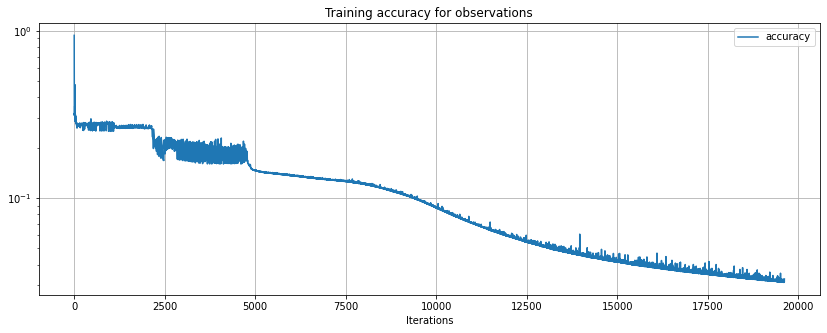

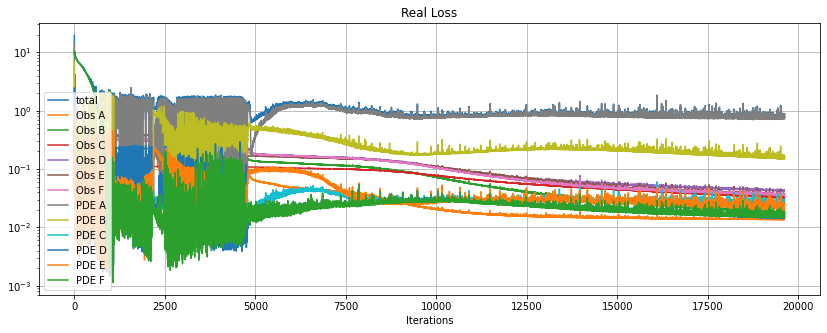

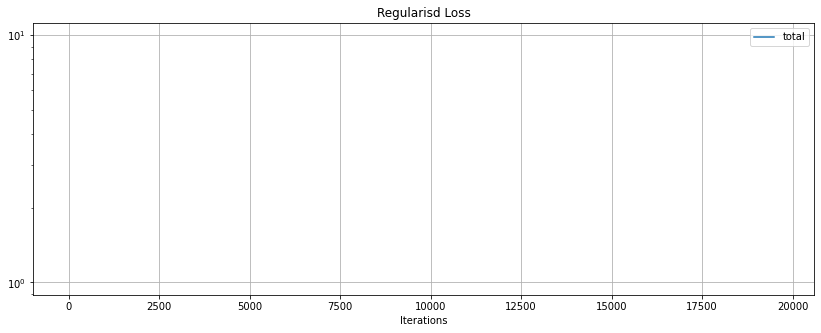

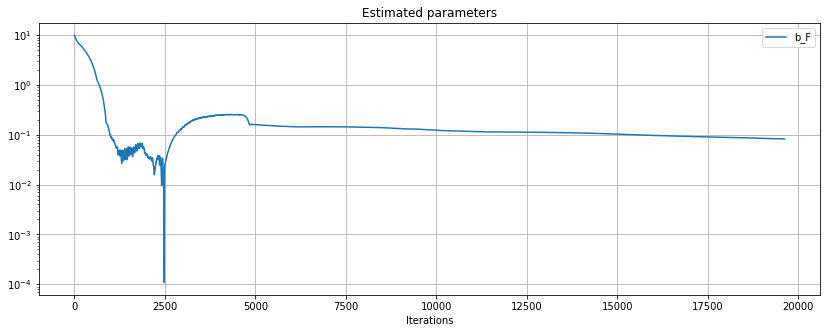

In [13]:
plot_result_multi_nodes(merge_dict_multi_nodes(results, results2, results3, results4, results5), 
                        param_names = ["b_F"],
                        node_names=node_names, yscale='log')

In [14]:
model.optimizer.lr.assign(2.5e-5)

results6 = model.train(
        epochs = 10000,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        X_pde = pde_X,
        print_interval=200,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=False,
        sample_gradients=False,
        regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.0311183743
total loss: 0.6993127306, total regularisd loss (sum of batches): -3588.9313354492
obs A loss: 0.0134567220, pde A loss: 0.6787277213
obs B loss: 0.0173213430, pde B loss: 0.1456583409
obs C loss: 0.0316269209, pde C loss: 0.0235826229
obs D loss: 0.0419441436, pde D loss: 0.0130566989
obs E loss: 0.0359605430, pde E loss: 0.0207821352
obs F loss: 0.0357249615, pde F loss: 0.0134904454
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.08271 
Time taken: 0.95s

Start of epoch 200
Training observations acc over epoch: 0.0307297222
total loss: 0.6456854712, total regularisd loss (sum of batches): -3607.8320388794
obs A loss: 0.0133867749, 


Start of epoch 2000
Training observations acc over epoch: 0.0292053446
total loss: 0.5815743903, total regularisd loss (sum of batches): -3673.7660140991
obs A loss: 0.0132863221, pde A loss: 0.5621413646
obs B loss: 0.0157295536, pde B loss: 0.1268364318
obs C loss: 0.0286912598, pde C loss: 0.0210695704
obs D loss: 0.0394956205, pde D loss: 0.0110818916
obs E loss: 0.0339910736, pde E loss: 0.0179997637
obs F loss: 0.0339894637, pde F loss: 0.0113987934
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.07957 
Time taken: 179.00s

Start of epoch 2200
Training observations acc over epoch: 0.0292550065
total loss: 0.6161048234, total regularisd loss (sum of batches): -3661.7880020142
obs A loss: 0.013352


Start of epoch 4000
Training observations acc over epoch: 0.0279983506
total loss: 0.5552072516, total regularisd loss (sum of batches): -3721.3415451050
obs A loss: 0.0132572936, pde A loss: 0.5377426532
obs B loss: 0.0147260651, pde B loss: 0.1157678902
obs C loss: 0.0261563986, pde C loss: 0.0211162204
obs D loss: 0.0380108482, pde D loss: 0.0102543424
obs E loss: 0.0331246593, pde E loss: 0.0178598483
obs F loss: 0.0329333849, pde F loss: 0.0105953474
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.07637 
Time taken: 178.54s

Start of epoch 4200
Training observations acc over epoch: 0.0278737992
total loss: 0.5662284720, total regularisd loss (sum of batches): -3724.8355789185
obs A loss: 0.013286


Start of epoch 6000
Training observations acc over epoch: 0.0268192030
total loss: 0.5350053946, total regularisd loss (sum of batches): -3767.7083740234
obs A loss: 0.0132305726, pde A loss: 0.5193286820
obs B loss: 0.0139518669, pde B loss: 0.1061167955
obs C loss: 0.0236246358, pde C loss: 0.0206682267
obs D loss: 0.0365422741, pde D loss: 0.0101488921
obs E loss: 0.0323331104, pde E loss: 0.0176597382
obs F loss: 0.0317336256, pde F loss: 0.0104910725
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.07314 
Time taken: 178.39s

Start of epoch 6200
Training observations acc over epoch: 0.0266475193
total loss: 0.5319155677, total regularisd loss (sum of batches): -3777.5099182129
obs A loss: 0.013149


Start of epoch 8000
Training observations acc over epoch: 0.0257095452
total loss: 0.4981144677, total regularisd loss (sum of batches): -3823.3090515137
obs A loss: 0.0131131555, pde A loss: 0.4837636979
obs B loss: 0.0131272718, pde B loss: 0.0959527435
obs C loss: 0.0213039507, pde C loss: 0.0194750557
obs D loss: 0.0350979789, pde D loss: 0.0092129282
obs E loss: 0.0315271376, pde E loss: 0.0189532316
obs F loss: 0.0306906748, pde F loss: 0.0097218135
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.06981 
Time taken: 178.29s

Start of epoch 8200
Training observations acc over epoch: 0.0255872328
total loss: 0.4970547907, total regularisd loss (sum of batches): -3831.6957397461
obs A loss: 0.013138

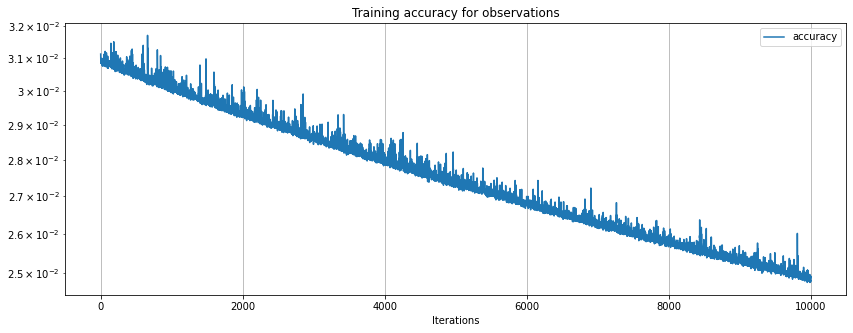

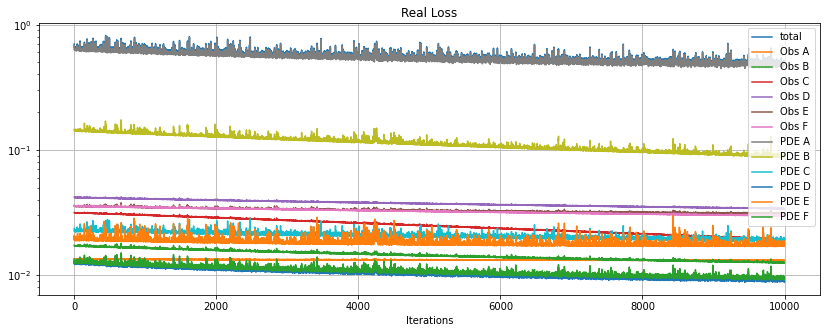

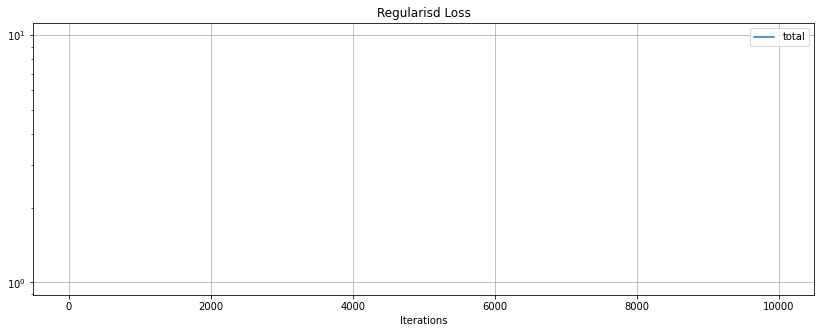

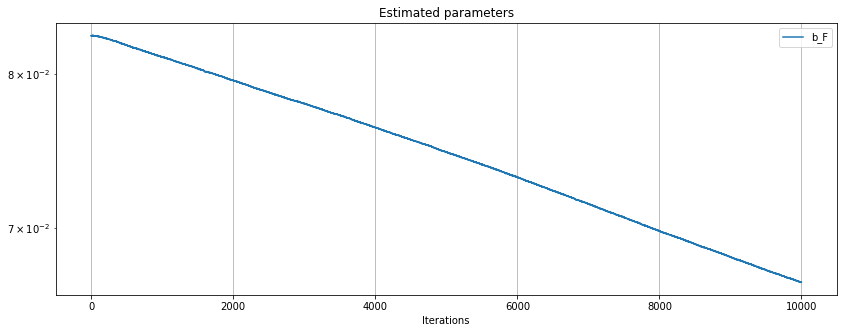

In [15]:
plot_result_multi_nodes(merge_dict_multi_nodes(results6), 
                        param_names = ["b_F"],
                        node_names=node_names, yscale='log')

In [16]:
results7 = model.train(
        epochs = 30000,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        X_pde = pde_X,
        print_interval=200,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=False,
        sample_gradients=False,
        regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.0248195715
total loss: 0.5071579047, total regularisd loss (sum of batches): -3863.6601791382
obs A loss: 0.0131480198, pde A loss: 0.4946041075
obs B loss: 0.0126223269, pde B loss: 0.0896433276
obs C loss: 0.0192530072, pde C loss: 0.0193942429
obs D loss: 0.0339393071, pde D loss: 0.0091978470
obs E loss: 0.0309361159, pde E loss: 0.0170396574
obs F loss: 0.0297367650, pde F loss: 0.0096351110
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.06676 
Time taken: 0.93s

Start of epoch 200
Training observations acc over epoch: 0.0248398725
total loss: 0.4862208981, total regularisd loss (sum of batches): -3867.1437225342
obs A loss: 0.0130802845, 


Start of epoch 2000
Training observations acc over epoch: 0.0240383837
total loss: 0.4852675290, total regularisd loss (sum of batches): -3906.8547973633
obs A loss: 0.0130564058, pde A loss: 0.4736380007
obs B loss: 0.0120820301, pde B loss: 0.0829392042
obs C loss: 0.0174509903, pde C loss: 0.0185476194
obs D loss: 0.0328095596, pde D loss: 0.0087924566
obs E loss: 0.0305431907, pde E loss: 0.0172613090
obs F loss: 0.0289262435, pde F loss: 0.0092937248
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.06399 
Time taken: 178.34s

Start of epoch 2200
Training observations acc over epoch: 0.0239905268
total loss: 0.4872656866, total regularisd loss (sum of batches): -3914.3968200684
obs A loss: 0.013054


Start of epoch 4000
Training observations acc over epoch: 0.0233406518
total loss: 0.4741502219, total regularisd loss (sum of batches): -3949.1845474243
obs A loss: 0.0130547025, pde A loss: 0.4635101056
obs B loss: 0.0116691295, pde B loss: 0.0769882418
obs C loss: 0.0158406547, pde C loss: 0.0178648519
obs D loss: 0.0318700061, pde D loss: 0.0086714087
obs E loss: 0.0300760674, pde E loss: 0.0174874329
obs F loss: 0.0281234665, pde F loss: 0.0089862073
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.06170 
Time taken: 178.09s

Start of epoch 4200
Training observations acc over epoch: 0.0232447237
total loss: 0.4748536073, total regularisd loss (sum of batches): -3956.1349716187
obs A loss: 0.012978


Start of epoch 6000
Training observations acc over epoch: 0.0226174630
total loss: 0.4613477310, total regularisd loss (sum of batches): -3989.9421005249
obs A loss: 0.0129419820, pde A loss: 0.4515262387
obs B loss: 0.0112267451, pde B loss: 0.0718138058
obs C loss: 0.0144631863, pde C loss: 0.0174253718
obs D loss: 0.0308949421, pde D loss: 0.0082111804
obs E loss: 0.0294501160, pde E loss: 0.0171757213
obs F loss: 0.0272905274, pde F loss: 0.0085551268
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05992 
Time taken: 178.63s

Start of epoch 6200
Training observations acc over epoch: 0.0226512309
total loss: 0.4750530150, total regularisd loss (sum of batches): -3986.6963043213
obs A loss: 0.012974


Start of epoch 8000
Training observations acc over epoch: 0.0221006759
total loss: 0.4664356014, total regularisd loss (sum of batches): -4023.7524108887
obs A loss: 0.0129590136, pde A loss: 0.4574266424
obs B loss: 0.0109624509, pde B loss: 0.0681452380
obs C loss: 0.0134070359, pde C loss: 0.0176317057
obs D loss: 0.0301301636, pde D loss: 0.0081184302
obs E loss: 0.0290487043, pde E loss: 0.0173844877
obs F loss: 0.0266669281, pde F loss: 0.0083437752
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05885 
Time taken: 177.69s

Start of epoch 8200
Training observations acc over epoch: 0.0219709687
total loss: 0.4518404292, total regularisd loss (sum of batches): -4031.1087036133
obs A loss: 0.012952


Start of epoch 10000
Training observations acc over epoch: 0.0214478783
total loss: 0.4521588632, total regularisd loss (sum of batches): -4068.0918426514
obs A loss: 0.0129089325, pde A loss: 0.4440437323
obs B loss: 0.0106202103, pde B loss: 0.0617459062
obs C loss: 0.0120533208, pde C loss: 0.0163736709
obs D loss: 0.0292116309, pde D loss: 0.0077648227
obs E loss: 0.0285050060, pde E loss: 0.0174794484
obs F loss: 0.0258747421, pde F loss: 0.0081396912
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05836 
Time taken: 178.99s

Start of epoch 10200
Training observations acc over epoch: 0.0214484576
total loss: 0.4856397806, total regularisd loss (sum of batches): -4059.2718048096
obs A loss: 0.0129


Start of epoch 12000
Training observations acc over epoch: 0.0210815463
total loss: 0.5021327981, total regularisd loss (sum of batches): -4077.9249496460
obs A loss: 0.0129030541, pde A loss: 0.4947125763
obs B loss: 0.0105430807, pde B loss: 0.0627845773
obs C loss: 0.0113281216, pde C loss: 0.0176128785
obs D loss: 0.0287362307, pde D loss: 0.0082068017
obs E loss: 0.0280728615, pde E loss: 0.0184506126
obs F loss: 0.0254314931, pde F loss: 0.0083861719
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05825 
Time taken: 178.43s

Start of epoch 12200
Training observations acc over epoch: 0.0208498966
total loss: 0.4725666459, total regularisd loss (sum of batches): -4097.4264221191
obs A loss: 0.0128


Start of epoch 14000
Training observations acc over epoch: 0.0204729680
total loss: 0.4729649687, total regularisd loss (sum of batches): -4123.5128479004
obs A loss: 0.0128986208, pde A loss: 0.4659021156
obs B loss: 0.0101484274, pde B loss: 0.0584515806
obs C loss: 0.0103415015, pde C loss: 0.0162735813
obs D loss: 0.0278923008, pde D loss: 0.0075995147
obs E loss: 0.0274862201, pde E loss: 0.0177100695
obs F loss: 0.0245981784, pde F loss: 0.0079631430
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05831 
Time taken: 177.86s

Start of epoch 14200
Training observations acc over epoch: 0.0203691013
total loss: 0.4691448099, total regularisd loss (sum of batches): -4129.4358596802
obs A loss: 0.0128


Start of epoch 16000
Training observations acc over epoch: 0.0199360587
total loss: 0.4655380949, total regularisd loss (sum of batches): -4156.6168060303
obs A loss: 0.0128389979, pde A loss: 0.4588322763
obs B loss: 0.0099325287, pde B loss: 0.0556448599
obs C loss: 0.0095576559, pde C loss: 0.0164962425
obs D loss: 0.0270801955, pde D loss: 0.0076422971
obs E loss: 0.0268895580, pde E loss: 0.0180060567
obs F loss: 0.0239468029, pde F loss: 0.0079298361
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05838 
Time taken: 177.61s

Start of epoch 16200
Training observations acc over epoch: 0.0199610312
total loss: 0.4786279381, total regularisd loss (sum of batches): -4153.1850357056
obs A loss: 0.0128


Start of epoch 18000
Training observations acc over epoch: 0.0194589291
total loss: 0.4683975735, total regularisd loss (sum of batches): -4185.3792190552
obs A loss: 0.0127986199, pde A loss: 0.4620838231
obs B loss: 0.0096756991, pde B loss: 0.0538912410
obs C loss: 0.0088912765, pde C loss: 0.0159917852
obs D loss: 0.0264285293, pde D loss: 0.0075837715
obs E loss: 0.0263395942, pde E loss: 0.0180095136
obs F loss: 0.0233062104, pde F loss: 0.0078146379
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05838 
Time taken: 177.23s

Start of epoch 18200
Training observations acc over epoch: 0.0195043068
total loss: 0.5136293747, total regularisd loss (sum of batches): -4166.7701110840
obs A loss: 0.0128


Start of epoch 20000
Training observations acc over epoch: 0.0189757254
total loss: 0.4721656294, total regularisd loss (sum of batches): -4219.8722686768
obs A loss: 0.0128091618, pde A loss: 0.4662600724
obs B loss: 0.0094267467, pde B loss: 0.0519056250
obs C loss: 0.0082122184, pde C loss: 0.0158606547
obs D loss: 0.0256719181, pde D loss: 0.0072646855
obs E loss: 0.0258837666, pde E loss: 0.0180589045
obs F loss: 0.0226069318, pde F loss: 0.0075367146
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05816 
Time taken: 177.72s

Start of epoch 20200
Training observations acc over epoch: 0.0188957099
total loss: 0.4707486360, total regularisd loss (sum of batches): -4222.6500473022
obs A loss: 0.0127


Start of epoch 22000
Training observations acc over epoch: 0.0187439267
total loss: 0.5318871116, total regularisd loss (sum of batches): -4219.1609039307
obs A loss: 0.0128042241, pde A loss: 0.5264573849
obs B loss: 0.0094640908, pde B loss: 0.0535810708
obs C loss: 0.0080022099, pde C loss: 0.0167182164
obs D loss: 0.0252365910, pde D loss: 0.0075607257
obs E loss: 0.0256730014, pde E loss: 0.0192459864
obs F loss: 0.0222366269, pde F loss: 0.0077787812
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05767 
Time taken: 177.59s

Start of epoch 22200
Training observations acc over epoch: 0.0185335763
total loss: 0.4805756667, total regularisd loss (sum of batches): -4242.4731216431
obs A loss: 0.0128


Start of epoch 24000
Training observations acc over epoch: 0.0182063878
total loss: 0.4826638162, total regularisd loss (sum of batches): -4264.9605026245
obs A loss: 0.0127457078, pde A loss: 0.4771855463
obs B loss: 0.0091644925, pde B loss: 0.0506509307
obs C loss: 0.0073586467, pde C loss: 0.0159835113
obs D loss: 0.0245488613, pde D loss: 0.0070903684
obs E loss: 0.0249359698, pde E loss: 0.0185364546
obs F loss: 0.0215359098, pde F loss: 0.0073901793
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05694 
Time taken: 178.07s

Start of epoch 24200
Training observations acc over epoch: 0.0180982687
total loss: 0.4533606936, total regularisd loss (sum of batches): -4281.8902816772
obs A loss: 0.0127


Start of epoch 26000
Training observations acc over epoch: 0.0177408196
total loss: 0.4482761884, total regularisd loss (sum of batches): -4310.0195999146
obs A loss: 0.0127452594, pde A loss: 0.4431147476
obs B loss: 0.0088919947, pde B loss: 0.0455607691
obs C loss: 0.0067799571, pde C loss: 0.0148528316
obs D loss: 0.0238817117, pde D loss: 0.0067811569
obs E loss: 0.0243733018, pde E loss: 0.0179026651
obs F loss: 0.0208937454, pde F loss: 0.0070398853
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05610 
Time taken: 177.08s

Start of epoch 26200
Training observations acc over epoch: 0.0176871866
total loss: 0.4750785559, total regularisd loss (sum of batches): -4306.7109222412
obs A loss: 0.0127


Start of epoch 28000
Training observations acc over epoch: 0.0173879676
total loss: 0.4764365859, total regularisd loss (sum of batches): -4328.5735931396
obs A loss: 0.0127080833, pde A loss: 0.4715814708
obs B loss: 0.0087350395, pde B loss: 0.0463204401
obs C loss: 0.0063828872, pde C loss: 0.0149010731
obs D loss: 0.0233834943, pde D loss: 0.0067845396
obs E loss: 0.0239673450, pde E loss: 0.0180348018
obs F loss: 0.0203541065, pde F loss: 0.0070554988
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05508 
Time taken: 177.90s

Start of epoch 28200
Training observations acc over epoch: 0.0173036661
total loss: 0.4774477451, total regularisd loss (sum of batches): -4329.5476455688
obs A loss: 0.0127

In [17]:
results8 = model.train(
        epochs = 3000,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        X_pde = pde_X,
        print_interval=200,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0
Training observations acc over epoch: 0.0169398356
total loss: 0.4381774817, total regularisd loss (sum of batches): -4366.5536117554
obs A loss: 0.0126735859, pde A loss: 0.4333481286
obs B loss: 0.0085142856, pde B loss: 0.0431863958
obs C loss: 0.0058952691, pde C loss: 0.0143170045
obs D loss: 0.0226890491, pde D loss: 0.0066034349
obs E loss: 0.0234289925, pde E loss: 0.0180474720
obs F loss: 0.0197527294, pde F loss: 0.0069138551
lambda obs A: 1.6785269976, lambda pde A: 0.3851834834
lambda obs B: 1.0280487537, lambda pde B: 0.8962181807
lambda obs C: 2.0649271011, lambda pde C: 0.4695843756
lambda obs D: 1.7637954950, lambda pde D: 0.2347655594
lambda obs E: 1.6673555374, lambda pde E: 0.1835689843
lambda obs F: 1.4070434570, lambda pde F: 0.2209821343
b_F: 0.05405 
Time taken: 4.03s

Start of epoch 200
Training observations acc over epoch: 0.0167130921
total loss: 0.5775805943, total regularisd loss (sum of batches): -4334.7866897583
obs A loss: 0.0127708826, 


Start of epoch 2000
Training observations acc over epoch: 0.0158426203
total loss: 0.7059539114, total regularisd loss (sum of batches): -4356.1967086792
obs A loss: 0.0125924443, pde A loss: 0.7009589325
obs B loss: 0.0079639156, pde B loss: 0.0676537301
obs C loss: 0.0066249412, pde C loss: 0.0224217417
obs D loss: 0.0206203564, pde D loss: 0.0076675328
obs E loss: 0.0217031757, pde E loss: 0.0179255488
obs F loss: 0.0185424137, pde F loss: 0.0078547576
lambda obs A: 3.6406373978, lambda pde A: 0.1828833222
lambda obs B: 1.0143131018, lambda pde B: 0.4587383866
lambda obs C: 0.6066546440, lambda pde C: 0.1881876588
lambda obs D: 1.6420061588, lambda pde D: 0.2073531300
lambda obs E: 2.0472073555, lambda pde E: 0.3097135425
lambda obs F: 1.4946523905, lambda pde F: 0.2076525986
b_F: 0.04839 
Time taken: 807.32s

Start of epoch 2200
Training observations acc over epoch: 0.0157340150
total loss: 0.7328337036, total regularisd loss (sum of batches): -4364.2458419800
obs A loss: 0.012575

In [18]:
results9 = model.train(
        epochs = 3000,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        X_pde = pde_X,
        print_interval=200,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0
Training observations acc over epoch: 0.0153038977
total loss: 0.7239567106, total regularisd loss (sum of batches): -4393.3208923340
obs A loss: 0.0125028294, pde A loss: 0.7198803772
obs B loss: 0.0077376677, pde B loss: 0.0600687488
obs C loss: 0.0066889243, pde C loss: 0.0214520662
obs D loss: 0.0198782210, pde D loss: 0.0071682854
obs E loss: 0.0207440559, pde E loss: 0.0175259511
obs F loss: 0.0178567252, pde F loss: 0.0073019571
lambda obs A: 3.7693955898, lambda pde A: 0.1977496892
lambda obs B: 1.0370093584, lambda pde B: 0.4591595531
lambda obs C: 0.6235831976, lambda pde C: 0.1985938102
lambda obs D: 1.6452348232, lambda pde D: 0.2072442174
lambda obs E: 2.0340125561, lambda pde E: 0.1278773248
lambda obs F: 1.4933749437, lambda pde F: 0.2067647129
b_F: 0.04601 
Time taken: 3.96s

Start of epoch 200
Training observations acc over epoch: 0.0165668502
total loss: 1.1788832196, total regularisd loss (sum of batches): -4250.4615554810
obs A loss: 0.0127246067, 


Start of epoch 2000
Training observations acc over epoch: 0.0145485783
total loss: 0.7680586055, total regularisd loss (sum of batches): -4429.5717773438
obs A loss: 0.0123878934, pde A loss: 0.7642095772
obs B loss: 0.0074451725, pde B loss: 0.0609678370
obs C loss: 0.0063918142, pde C loss: 0.0227806884
obs D loss: 0.0186689827, pde D loss: 0.0069920851
obs E loss: 0.0196512500, pde E loss: 0.0170560967
obs F loss: 0.0168972958, pde F loss: 0.0072063773
lambda obs A: 3.7889957428, lambda pde A: 0.1808783710
lambda obs B: 0.9904818535, lambda pde B: 0.4930343032
lambda obs C: 0.6320860386, lambda pde C: 0.1732868403
lambda obs D: 1.5721147060, lambda pde D: 0.2088154107
lambda obs E: 1.9896850586, lambda pde E: 0.3101289868
lambda obs F: 1.4505223036, lambda pde F: 0.2099709511
b_F: 0.04189 
Time taken: 802.90s

Start of epoch 2200
Training observations acc over epoch: 0.0144881476
total loss: 0.8153890006, total regularisd loss (sum of batches): -4431.7704010010
obs A loss: 0.012385

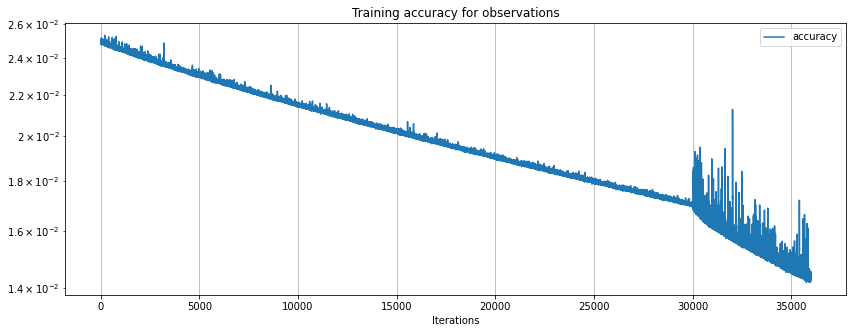

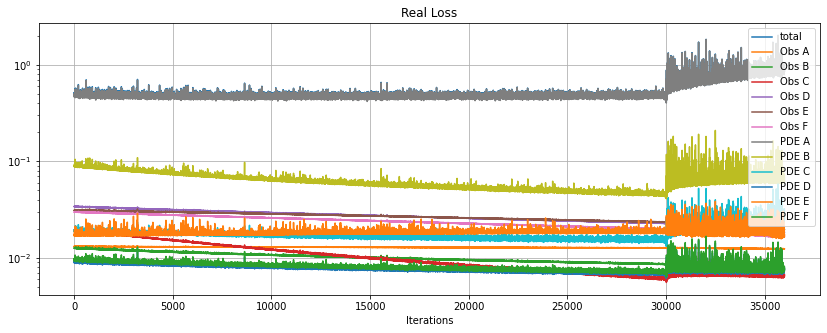

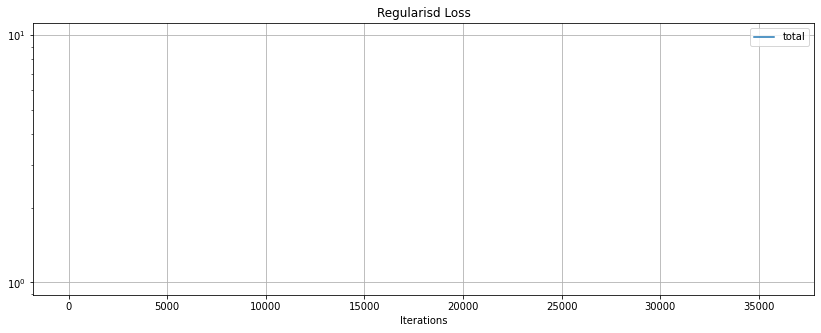

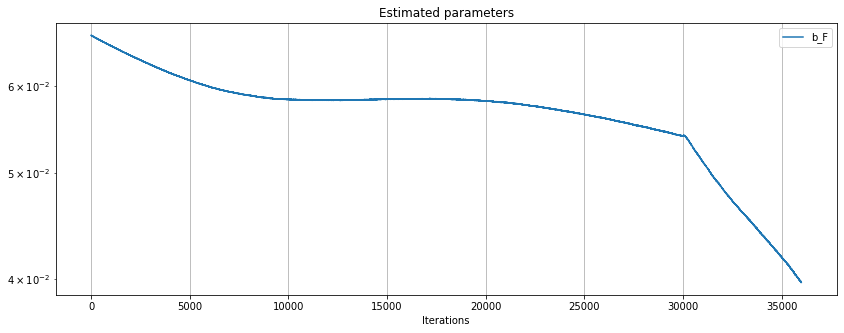

In [19]:
plot_result_multi_nodes(merge_dict_multi_nodes(results7, results8, results9), 
                        param_names = ["b_F"],
                        node_names=node_names, yscale='log')

In [20]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size

T_test_index = 0#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

118


In [21]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

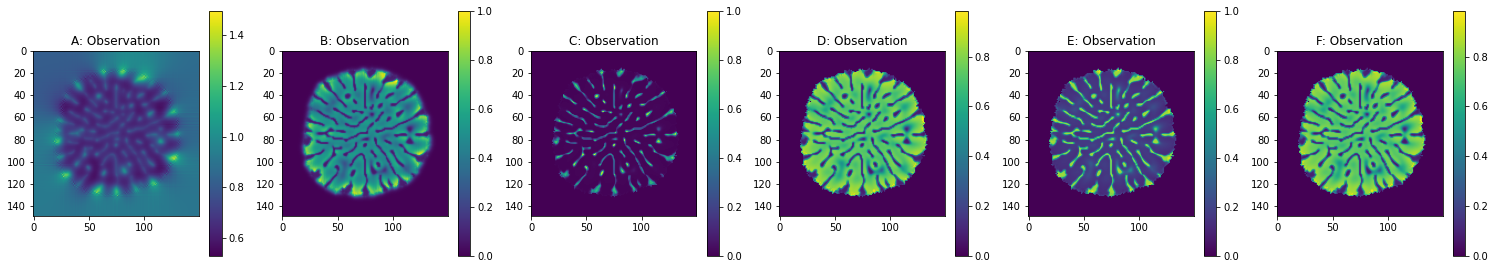

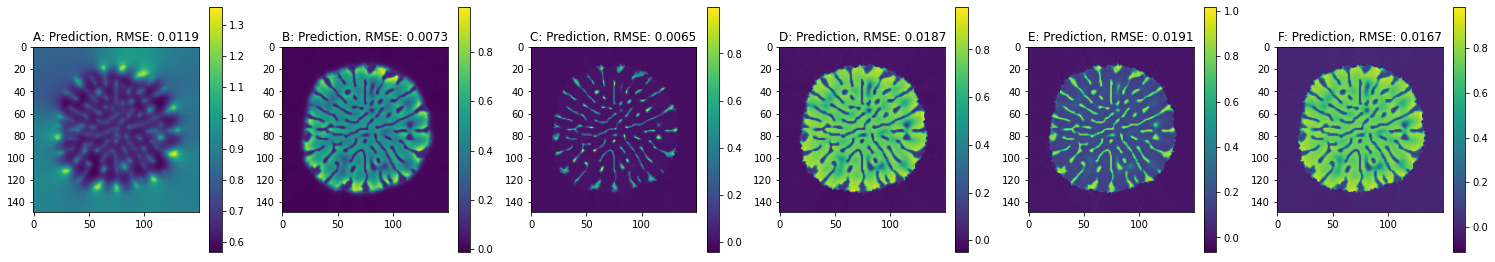

In [22]:
data_original = data.copy()#np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    #plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.imshow(data_original[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    #rmse = np.sqrt(np.mean((output_test[i,:, :] - data_original[i,:, :, t_star[T_test_index]])**2))
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data_original[i,:, :, T_test_index])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [23]:
test_d = np.vstack([XX_test, YY_test, TT_test]).T

In [24]:
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pdes = np.zeros((test_d.shape[0], len(node_names)))

for i, _ in enumerate(test_d):
    outs, pde_outs = pde_loss.loss_multi_nodes(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pdes[i] = [item.numpy() for item in pde_outs]

In [25]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pdes = np.array([ test_pdes[:, i].reshape((x_size, y_size)) for i in range(test_pdes.shape[1])]) 

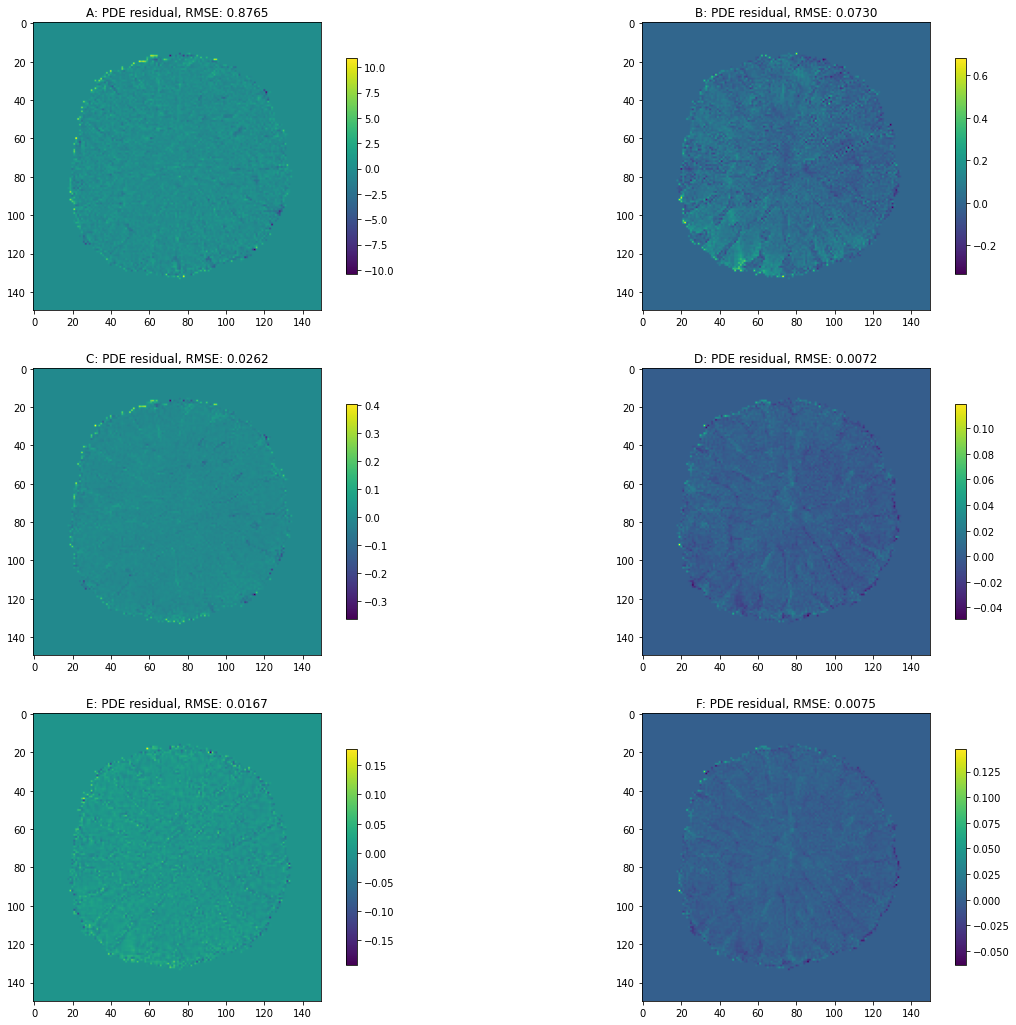

In [26]:
_ = plt.figure(figsize=(20,18))
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    #d[mask[:,:,t_star[T_test_index]] == 0] = 0
    #rmse = np.sqrt(np.mean(d**2))
    rmse = np.sqrt(np.mean(d[mask[:,:,t_star[T_test_index]] != 0]**2))
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    plt.title(f"{name}: PDE residual, RMSE: {rmse:.4f}")
    
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()

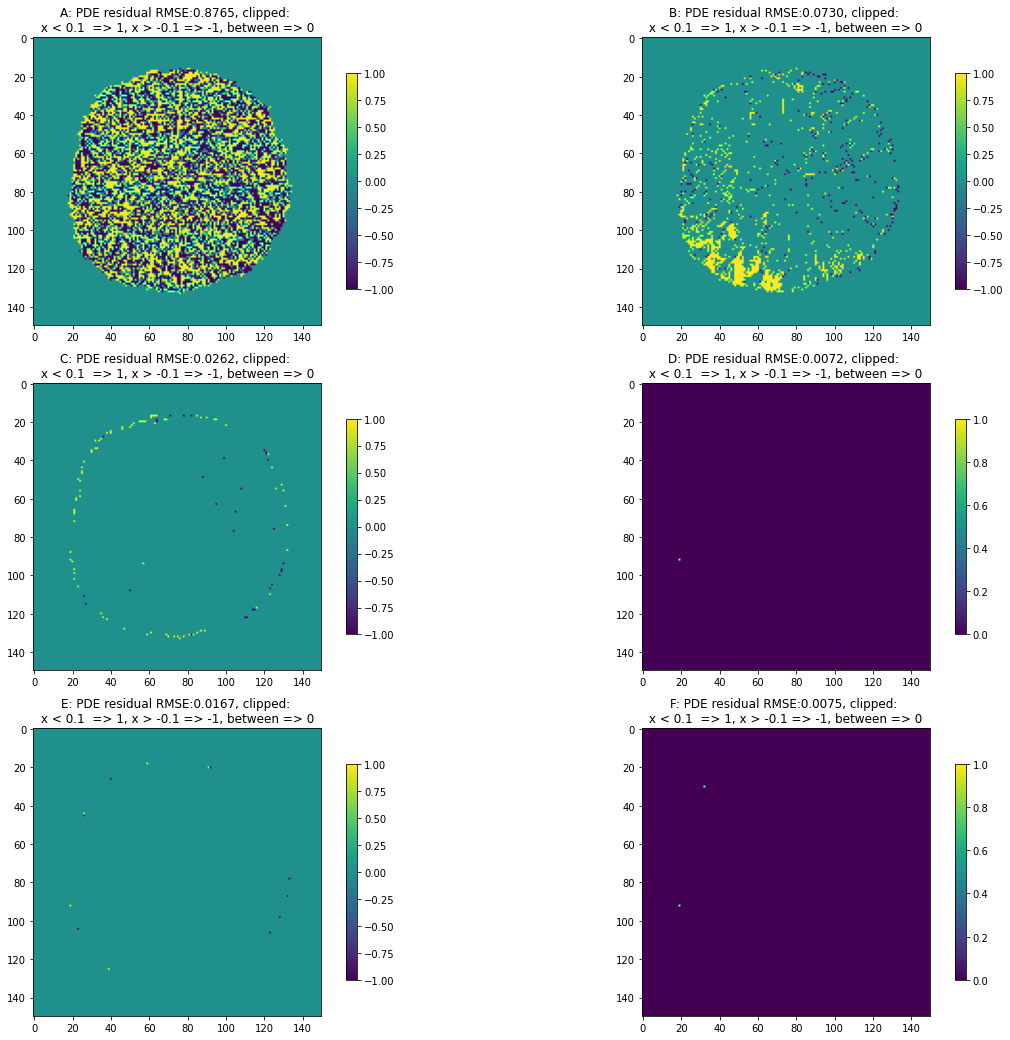

In [27]:
_ = plt.figure(figsize=(20,18))
max_L = .1
min_L = -.1
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    #d[mask[:,:,t_star[T_test_index]] == 0] = 0
    #rmse = np.sqrt(np.mean(d**2))    
    rmse = np.sqrt(np.mean(d[mask[:,:,t_star[T_test_index]] != 0]**2))
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    plt.title(f"{name}: PDE residual RMSE:{rmse:.4f}, clipped: \n x < {max_L}  => 1, x > {min_L} => -1, between => 0 ")    
    d[(d >= min_L) & (d <= max_L)] = 0
    d[d > max_L] = 1
    d[d < min_L] = -1
    #d[d > 0] = 0
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()

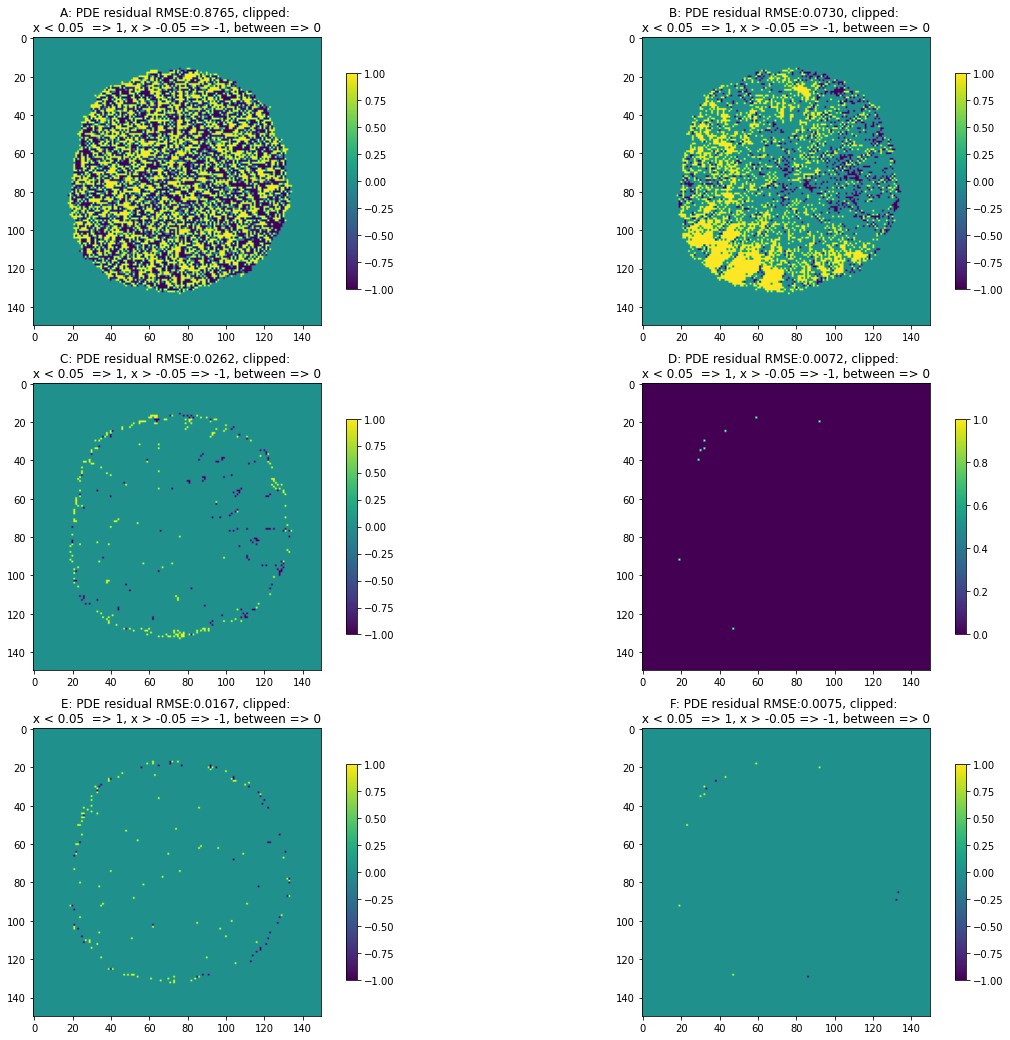

In [28]:
_ = plt.figure(figsize=(20,18))
max_L = .05
min_L = -.05
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    #d[mask[:,:,t_star[T_test_index]] == 0] = 0
    #rmse = np.sqrt(np.mean(d**2))    
    rmse = np.sqrt(np.mean(d[mask[:,:,t_star[T_test_index]] != 0]**2))
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    plt.title(f"{name}: PDE residual RMSE:{rmse:.4f}, clipped: \n x < {max_L}  => 1, x > {min_L} => -1, between => 0 ")    
    d[(d >= min_L) & (d <= max_L)] = 0
    d[d > max_L] = 1
    d[d < min_L] = -1
    #d[d > 0] = 0
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()